### Pytorch - classifier
- CNN을 활용한 모델을 만들어서 CIFAR-10에 대하여 정확도 95% 이상의 Classifier를 만드세요
- 예제 코드는 MNIST에 대한 코드

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


torch.manual_seed(0) # seed 고정 - 여러번 실행해도 같은 결과가 나오도록 설정

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Dataset download

In [123]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# CIFAR10
train_data = datasets.CIFAR10(root= 'data', 
                              train= True, 
                              transform= transform, 
                              download= True)
dataloader_train = DataLoader(train_data, 
                              batch_size=128, 
                              shuffle=True)

test_data = datasets.CIFAR10(root= 'data',
                             train= False,
                             transform= transform,
                             download= True)
dataloader_test = DataLoader(test_data, 
                              batch_size=128, 
                              shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


#### Check images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Data shape: torch.Size([3, 32, 32])


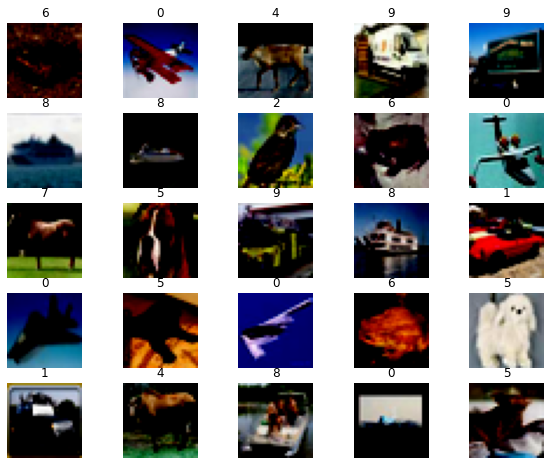

In [115]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
# plt.show()
print('Data shape:', img.shape)

#### CNN

In [136]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                    )
        self.conv3 = nn.Sequential(
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                    )
        self.conv4 = nn.Sequential(
                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                    )
        self.conv5 = nn.Sequential(
                        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                    )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(512 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # flatten the output of conv2 to (batch_size, 128 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.out(x)
        return output   # return x for visualization

#### Train

In [138]:
cnn = CNN()
cnn = cnn.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)

# Train the model
num_epochs = 30

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train, 1):
        images, labels = images.to(device), labels.to(device)
        output = cnn(images)
        loss = loss_func(output, labels)

        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients 
        loss.backward()
        # apply gradients
        optimizer.step()

        # if i % 100 == 0:
        #     print (f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")
    print (f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")

Epoch [1/30], Step [391], Loss: 0.9803
Epoch [2/30], Step [391], Loss: 0.9009
Epoch [3/30], Step [391], Loss: 0.7646
Epoch [4/30], Step [391], Loss: 0.7293
Epoch [5/30], Step [391], Loss: 0.6138
Epoch [6/30], Step [391], Loss: 0.5220
Epoch [7/30], Step [391], Loss: 0.7579
Epoch [8/30], Step [391], Loss: 0.3541
Epoch [9/30], Step [391], Loss: 0.3314
Epoch [10/30], Step [391], Loss: 0.2653
Epoch [11/30], Step [391], Loss: 0.5290
Epoch [12/30], Step [391], Loss: 0.4454
Epoch [13/30], Step [391], Loss: 0.6212
Epoch [14/30], Step [391], Loss: 0.2885
Epoch [15/30], Step [391], Loss: 0.1167
Epoch [16/30], Step [391], Loss: 0.2402
Epoch [17/30], Step [391], Loss: 0.2339
Epoch [18/30], Step [391], Loss: 0.2002
Epoch [19/30], Step [391], Loss: 0.2439
Epoch [20/30], Step [391], Loss: 0.0829
Epoch [21/30], Step [391], Loss: 0.0841
Epoch [22/30], Step [391], Loss: 0.1381
Epoch [23/30], Step [391], Loss: 0.0999
Epoch [24/30], Step [391], Loss: 0.1172
Epoch [25/30], Step [391], Loss: 0.0863
Epoch [26

#### Test

In [7]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        test_output = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 96.63 Percent


In [ ]:
print(f"predict: {pred_y}")
print(f"labels : {labels}")

In [139]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        test_output = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print(f"Test Accuracy of the model on the 10000 test images: {accuracy:.2f} Percent")

Test Accuracy of the model on the 10000 test images: 77.99 Percent
